# Stacking Data and Getting Prediction

The notebook is a draft of the final pipeline producing the data product with upscaled ET.

In [2]:
import numpy as np
import pandas as pd
import rasterio
import geopandas as gpd
import rioxarray as rxr
import xarray as xr

import joblib
import lightgbm as lgb

import os
from os import listdir
from os.path import join, getsize
import zipfile
import tempfile
import subprocess

import matplotlib.pyplot as plt

from src.PM_eq import penman_monteith
import src.config as config

In [3]:
import warnings

warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [4]:
startYear, endYear = 2019, 2024
bbox=[-104.,   36.,  -82.,   49.]

In [5]:
root_dir = '/home/runck014/shared/et_upscaling'

In [5]:
'''Checking if any dates are missing'''
sources = ['ERA5', 'MODIS', 'MODIS_Clouds']
size_thresholds = {'ERA5':1, 'MODIS':400, 'MODIS_Clouds': 5}
files2derive = {'ERA5': [], 'MODIS': [], 'MODIS_Clouds': []}
for source in sources:
    for year in range(startYear, endYear+1):
        if year%4==0:
            days = 366
        else:
            days = 365
        files  = listdir(f'{root_dir}/{source}/{year}')
        days = list(range(1, days+1))
        for d in days:
            if f'{source}_{year}_{d}.tif' not in files:
                print(f'Absent: {source}_{year}_{d}.tif')
                files2derive[source].append(f'{source}_{year}_{d}.tif')
            else:
                size = getsize(f'{root_dir}/{source}/{year}/{source}_{year}_{d}.tif')
                size_mb = size / (1024 * 1024)
                
                if size_mb<size_thresholds[source]:
                    try:
                        modis_fname=f'{root_dir}/{source}/{year}/{source}_{year}_{d}.tif'
                        mod = rxr.open_rasterio(modis_fname, mask_and_scale=True)
                    except Exception:
                        print(f'Invalid ({size_mb} Mb): {source}_{year}_{d}.tif')
                        files2derive[source].append(f'{source}_{year}_{d}.tif')
files2derive = [item for sublist in [files2derive[key] for key in files2derive.keys()] for item in sublist]
with open('./files2derive.txt', 'w') as file:
    for item in files2derive:
        file.write(f"{item}\n")

Absent: MODIS_2022_284.tif
Absent: MODIS_2022_285.tif
Absent: MODIS_2022_286.tif
Absent: MODIS_2022_287.tif
Absent: MODIS_2022_288.tif
Absent: MODIS_2022_289.tif
Absent: MODIS_2022_290.tif
Absent: MODIS_2022_291.tif
Absent: MODIS_2022_292.tif
Absent: MODIS_2022_293.tif
Absent: MODIS_2022_294.tif
Absent: MODIS_2022_295.tif
Absent: MODIS_Clouds_2022_284.tif
Absent: MODIS_Clouds_2022_285.tif
Absent: MODIS_Clouds_2022_286.tif
Absent: MODIS_Clouds_2022_287.tif
Absent: MODIS_Clouds_2022_288.tif
Absent: MODIS_Clouds_2022_289.tif
Absent: MODIS_Clouds_2022_290.tif
Absent: MODIS_Clouds_2022_291.tif
Absent: MODIS_Clouds_2022_292.tif
Absent: MODIS_Clouds_2022_293.tif
Absent: MODIS_Clouds_2022_294.tif
Absent: MODIS_Clouds_2022_295.tif


In [6]:
def extract_year_doy(fname):
    # 'MODIS_2019_1.tif' -> ['MODIS', '2019', '1.tif']
    parts = fname.replace('.tif', '').split('_')
    year = int(parts[1])
    doy = int(parts[2].split('.')[0])
    return (year, doy)
raw_f = listdir(join(root_dir,'ET_raw'))
sorted_fnames = sorted(raw_f, key=extract_year_doy)

In [7]:
'''Get daily ET estimations as .npz files and save missing one in a txt file'''

all_mod = [listdir(join(root_dir, 'MODIS', str(year))) for year in range(2019,2025)]
all_mod = [sub for l in all_mod for sub in l]
gaps_mod = [
    'MODIS_2022_284.tif',
    'MODIS_2022_285.tif',
    'MODIS_2022_286.tif',
    'MODIS_2022_287.tif',
    'MODIS_2022_288.tif',
    'MODIS_2022_289.tif',
    'MODIS_2022_290.tif',
    'MODIS_2022_291.tif',
    'MODIS_2022_292.tif',
    'MODIS_2022_293.tif',
    'MODIS_2022_294.tif',
    'MODIS_2022_295.tif',
]
to_process = []
total=0
for modname in all_mod:
    if modname.replace('MODIS', 'ET').replace('tif', 'npz') not in sorted_fnames:
        total+=1
        to_process.append(modname)
for gap in gaps_mod:
    if gap.replace('MODIS', 'ET').replace('tif', 'npz') not in sorted_fnames:
        total+=1
        to_process.append(gap)
print(total)
np.savetxt('./remaining_files.txt', to_process, fmt='%s',delimiter='\n')

0


In [9]:
'''Raw .npz to yearly .nc'''
for year in range(2019,2025): 
    ETs = []
    dates = []
    for fname in sorted_fnames:
        if str(year) in fname:
            doy = int(fname.split('_')[-1].split('.')[0])
            
            try:
                npz_path = f'{root_dir}/ET_raw/{fname}'
                data = np.load(npz_path)
                ET0 = data['ET'] 
            except:
                with tempfile.TemporaryDirectory() as temp_dir:
                    result = subprocess.run(['unzip', '-o', npz_path, '-d', temp_dir], capture_output=True, text=True) # Unzip the file using terminal command
                    if result.returncode != 0:
                        continue
                    else:
                        et_path = os.path.join(temp_dir, 'ET.npy')
                        ET0 = np.load(et_path, allow_pickle=True)
                    
            ETs.append(ET0.copy())
            dates.append(pd.to_datetime(f"{year}-{doy:03d}", format="%Y-%j"))
            x, y = data['x'], data['y']
    
    ET = np.array(ETs).astype(np.float32)
    da = xr.DataArray(
        ET,
        coords={'date': dates, 'y': y, 'x': x},
        dims=['date', 'y', 'x'],
        name='Evapotranspiration'
    )
    
    et_file = f'{root_dir}/ET_new/ET_{year}.nc'  
    da.to_netcdf(et_file, format="NETCDF4", engine="netcdf4")

# Data Product Visualization

In [10]:
data = []
for year in range(2019, 2025): 
    ds = xr.open_dataset(f'{root_dir}/ET_new/ET_{year}.nc')#.mean('date')
    data.append(ds.mean(['x','y']).Evapotranspiration.values)

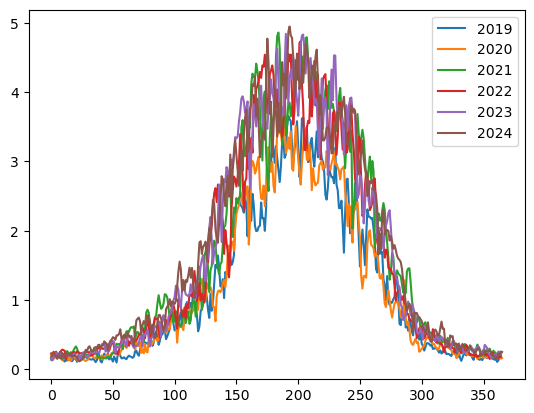

In [11]:
fig, ax = plt.subplots(1,1)
for idx, i in enumerate(range(2019,2025)): #2025
    ax.plot(data[idx], label=i)
plt.legend()
plt.show()

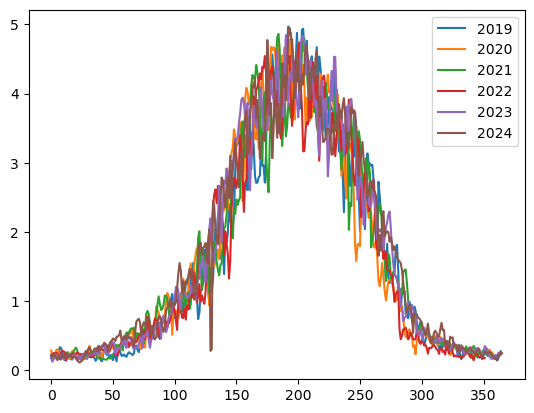

In [15]:
fig, ax = plt.subplots(1,1)
for idx, i in enumerate(range(2019,2025)):
    ax.plot(data[idx], label=i)
plt.legend()
plt.show()

In [8]:
data = []
for year in range(2019, 2025):
    ds = xr.open_dataset(f'{root_dir}/ET_new/ET_{year}.nc').sum('date')
    data.append(ds.Evapotranspiration.values)
# data = np.concatenate(data, axis=0)

In [9]:
data = np.mean(np.array(data), axis=0)
data.shape

(1468, 2514)

In [26]:
plt.rcParams.update({'font.size': 20, 'font.family':'monospace', 'figure.figsize': (16, 9)})

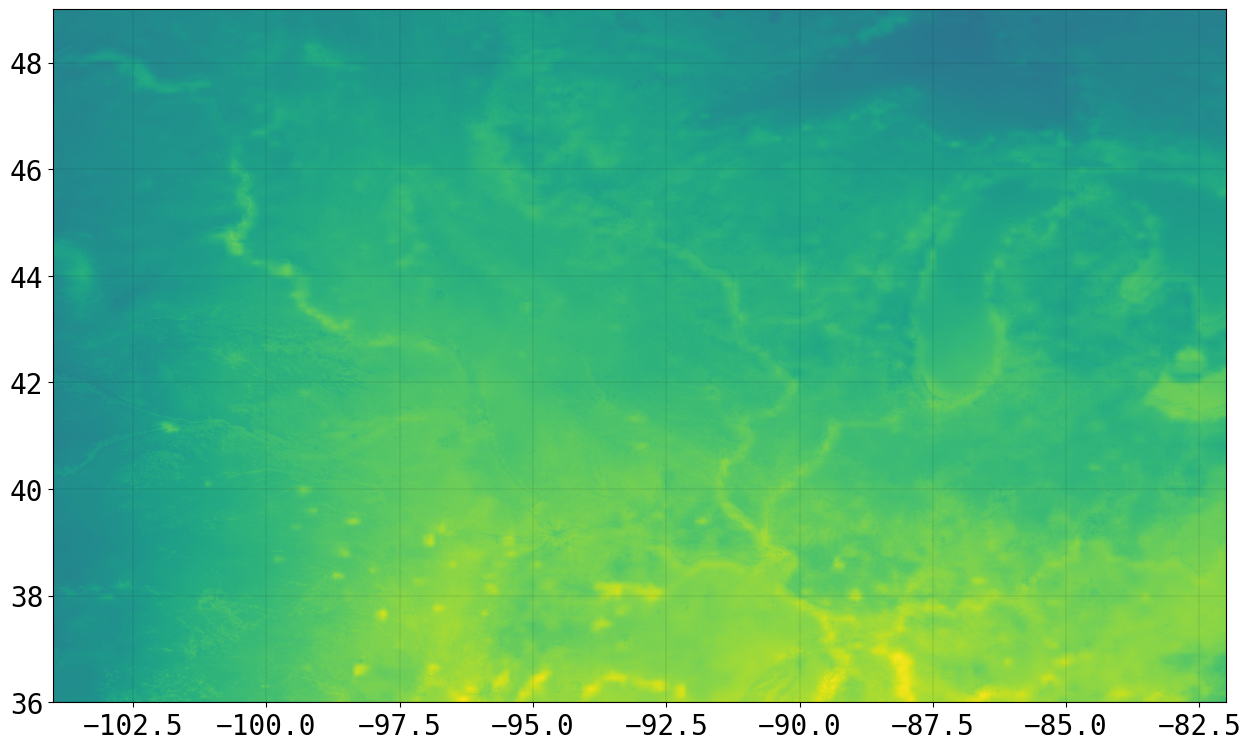

In [43]:
fig, ax = plt.subplots(1,1)
extent = [-104.0, -82.0, 36.0, 49.0]
ax.imshow(data, extent=extent)
ax.grid(True, lw=0.1, ls='--', color='black')

In [10]:
import rasterio
from rasterio.transform import from_bounds

height, width = data.shape

transform = from_bounds(*bbox, width=width, height=height)

with rasterio.open(
    '/home/runck014/shared/et_upscaling/average_ET_2019_2024.tif',
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype=np.float32,
    crs='EPSG:4326',
    transform=transform,
) as dst:
    dst.write(data, 1)

# Meta Info

In [11]:
from datetime import date

message = {
    "title": "ET-MW500 v1.0: A 500 m daily evapotranspiration product for the U.S. Midwest (2019–2024) generated via LightGBM with physically informed features.",
    "summary": "This dataset provides daily estimates of evapotranspiration (ET) at 500 m resolution from 2019 to 2024, generated using a LightGBM model trained on flux tower data and remote sensing inputs. It supports applications in agriculture, drought monitoring, and hydrological modeling.",
    "institution": "University of Minnesota",
    "authors": "Aleksei Rozanov, Samikshya Subedi, Vasudha Sharma, Bryan Runck",
    "creator_email": "runck014@umn.edu ",
    "date_created": str(date.today()),
    "license": "CC-BY-4.0: https://creativecommons.org/licenses/by/4.0/",
    "acknowledgment": "This dataset was funded by the Minnesota Environment and Natural Resources Trust Fund as recommended by the Legislative-Citizen Commission on Minnesota Resources (LCCMR).",
    "git": "https://github.com/RTGS-Lab/ET_LCCMR"
}

In [12]:
for year in range(2019, 2025):
    et_file = f'{root_dir}/ET_new/ET_{year}.nc'  
    ds = xr.open_dataset(et_file)
    ds = ds.rename({"Evapotranspiration": "et"})
    ds.attrs.update(message)
    ds['et'].attrs.update({
        "long_name": "Evapotranspiration",
        "units": "mm day-1",
    })
    os.remove(et_file)
    ds.to_netcdf(et_file)

In [13]:
et_file = f'{root_dir}/ET_new/ET_{year}.nc'  
ds = xr.open_dataset(et_file)
ds

<xarray.Dataset> Size: 5GB
Dimensions:  (date: 366, y: 1468, x: 2514)
Coordinates:
  * date     (date) datetime64[ns] 3kB 2024-01-01 2024-01-02 ... 2024-12-31
  * y        (y) float64 12kB 48.99 48.98 48.98 48.97 ... 36.18 36.17 36.16
  * x        (x) float64 20kB -104.0 -104.0 -104.0 ... -82.03 -82.02 -82.01
Data variables:
    et       (date, y, x) float32 5GB ...
Attributes:
    title:           ET-MW500 v1.0: A 500 m daily evapotranspiration product ...
    summary:         This dataset provides daily estimates of evapotranspirat...
    institution:     University of Minnesota
    authors:         Aleksei Rozanov, Samikshya Subedi, Vasudha Sharma, Bryan...
    creator_email:   runck014@umn.edu 
    date_created:    2025-08-12
    license:         CC-BY-4.0: https://creativecommons.org/licenses/by/4.0/
    acknowledgment:  This dataset was funded by the Minnesota Environment and...
    git:             https://github.com/RTGS-Lab/ET_LCCMR